In [1]:
!pip install --upgrade peft diffusers accelerate transformers safetensors

In [2]:
import torch
import numpy as np
from PIL import Image

from transformers import DPTFeatureExtractor, DPTForDepthEstimation
from diffusers import ControlNetModel, StableDiffusionControlNetImg2ImgPipeline, AutoencoderKL
from diffusers.utils import load_image

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

depth_estimator = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas").to(device)
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-hybrid-midas")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/dpt/feature_extraction_dpt.py:28: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(


In [4]:
controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-depth-sdxl-1.0-small",
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16
).to(device)

In [5]:
!pip install torchinfo

In [6]:
from torchinfo import summary

summary(depth_estimator)

Layer (type:depth-idx)                                                                     Param #
DPTForDepthEstimation                                                                      --
├─DPTModel: 1-1                                                                            --
│    └─DPTViTHybridEmbeddings: 2-1                                                         443,904
│    │    └─BitBackbone: 3-1                                                               11,894,848
│    │    └─Conv2d: 3-2                                                                    787,200
│    └─DPTViTEncoder: 2-2                                                                  --
│    │    └─ModuleList: 3-3                                                                85,054,464
│    └─LayerNorm: 2-3                                                                      1,536
├─DPTNeck: 1-2                                                                             --
│    └─DPTReassembleStage:

In [7]:
summary(controlnet)

Layer (type:depth-idx)                        Param #
ControlNetModel                               --
├─Conv2d: 1-1                                 11,840
├─Timesteps: 1-2                              --
├─TimestepEmbedding: 1-3                      --
│    └─Linear: 2-1                            410,880
│    └─SiLU: 2-2                              --
│    └─Linear: 2-3                            1,639,680
├─Timesteps: 1-4                              --
├─TimestepEmbedding: 1-5                      --
│    └─Linear: 2-4                            3,605,760
│    └─SiLU: 2-5                              --
│    └─Linear: 2-6                            1,639,680
├─ControlNetConditioningEmbedding: 1-6        --
│    └─Conv2d: 2-7                            448
│    └─ModuleList: 2-8                        --
│    │    └─Conv2d: 3-1                       2,320
│    │    └─Conv2d: 3-2                       4,640
│    │    └─Conv2d: 3-3                       9,248
│    │    └─Conv2d: 3-4 

In [8]:
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16).to(device)

In [9]:
summary(vae)

Layer (type:depth-idx)                             Param #
AutoencoderKL                                      --
├─Encoder: 1-1                                     --
│    └─Conv2d: 2-1                                 3,584
│    └─ModuleList: 2-2                             --
│    │    └─DownEncoderBlock2D: 3-1                738,944
│    │    └─DownEncoderBlock2D: 3-2                2,690,304
│    │    └─DownEncoderBlock2D: 3-3                10,754,560
│    │    └─DownEncoderBlock2D: 3-4                9,443,328
│    └─UNetMidBlock2D: 2-3                         --
│    │    └─ModuleList: 3-5                        1,051,648
│    │    └─ModuleList: 3-6                        9,443,328
│    └─GroupNorm: 2-4                              1,024
│    └─SiLU: 2-5                                   --
│    └─Conv2d: 2-6                                 36,872
├─Decoder: 1-2                                     --
│    └─Conv2d: 2-7                                 18,944
│    └─ModuleList: 2-8

In [10]:
from diffusers import StableDiffusionXLControlNetImg2ImgPipeline

pipe = StableDiffusionXLControlNetImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnet,
    vae=vae,
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16,
).to(device)

pipe.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [11]:
summary(pipe.unet)

Layer (type:depth-idx)                                            Param #
UNet2DConditionModel                                              --
├─Conv2d: 1-1                                                     11,840
├─Timesteps: 1-2                                                  --
├─TimestepEmbedding: 1-3                                          --
│    └─Linear: 2-1                                                410,880
│    └─SiLU: 2-2                                                  --
│    └─Linear: 2-3                                                1,639,680
├─Timesteps: 1-4                                                  --
├─TimestepEmbedding: 1-5                                          --
│    └─Linear: 2-4                                                3,605,760
│    └─SiLU: 2-5                                                  --
│    └─Linear: 2-6                                                1,639,680
├─ModuleList: 1-6                                                 --

In [12]:
import imageio
import requests
import torch
from diffusers.utils import export_to_gif
from io import BytesIO
from PIL import Image

In [28]:
def get_depth_map(image):
  image = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)
  with torch.no_grad(), torch.autocast(device):
    depth_map = depth_estimator(image).predicted_depth

  depth_map = torch.nn.functional.interpolate(
      depth_map.unsqueeze(1),
      size=(1024,1024),
      mode="bicubic",
      align_corners=False,
  )
  depth_min = torch.amin(depth_map, dim=[1, 2, 3], keepdim=True)
  depth_max = torch.amax(depth_map, dim=[1, 2, 3], keepdim=True)
  depth_map = (depth_map - depth_min) / (depth_max / depth_min)
  image = torch.cat([depth_map] * 3, dim=1)
  image = image.permute(0, 2, 3, 1).cpu().numpy()[0]
  image = Image.fromarray((image * 255.0).clip(0, 255).astype(np.uint8))
  return image

In [29]:
prompt = "A robot, 4k photo"
image = load_image(

    "https://huggingface.co/datasets/hf-internal-testing/diffusers-images/resolve/main/kandinsky/cat.png"
).resize((1024, 1024))
controlnet_conditioning_scale = 0.5 # recomended for good generalization
depth_image = get_depth_map(image)

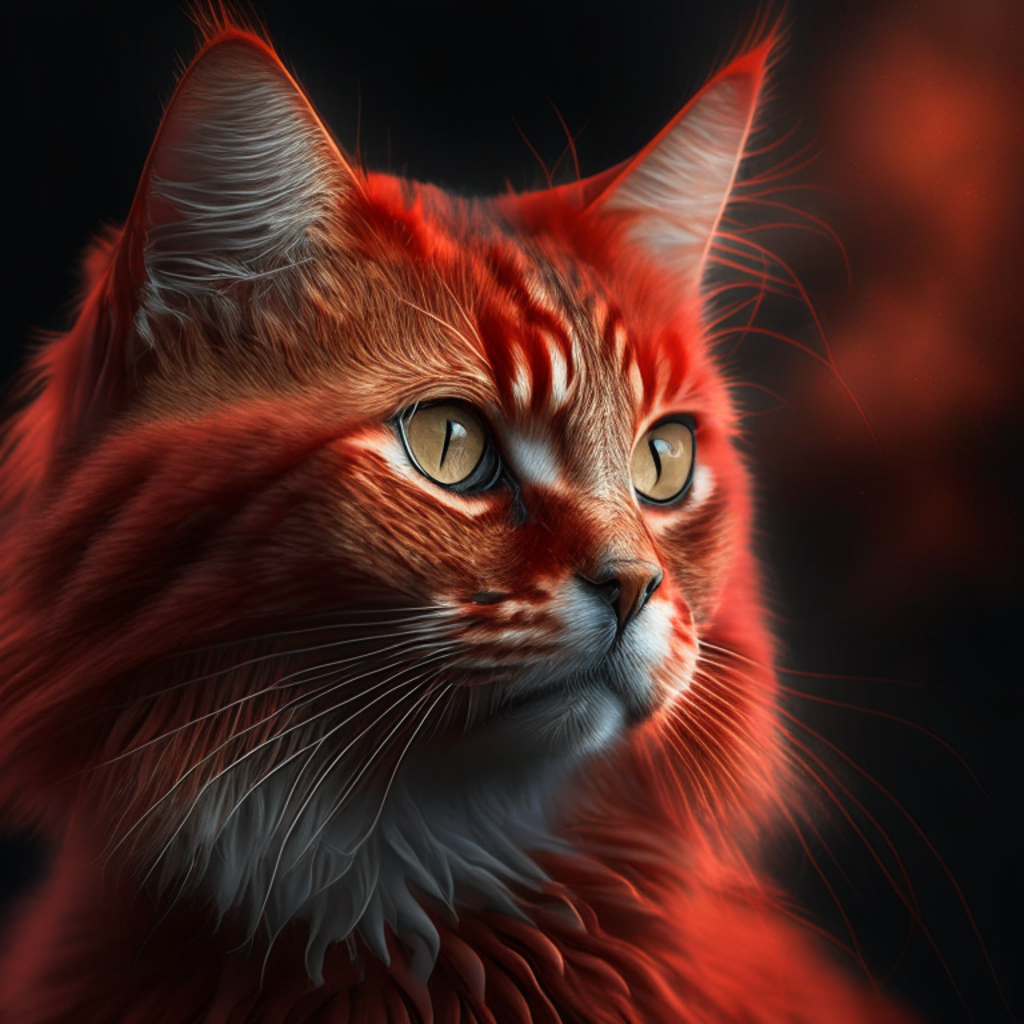

  0%|          | 0/49 [00:00<?, ?it/s]

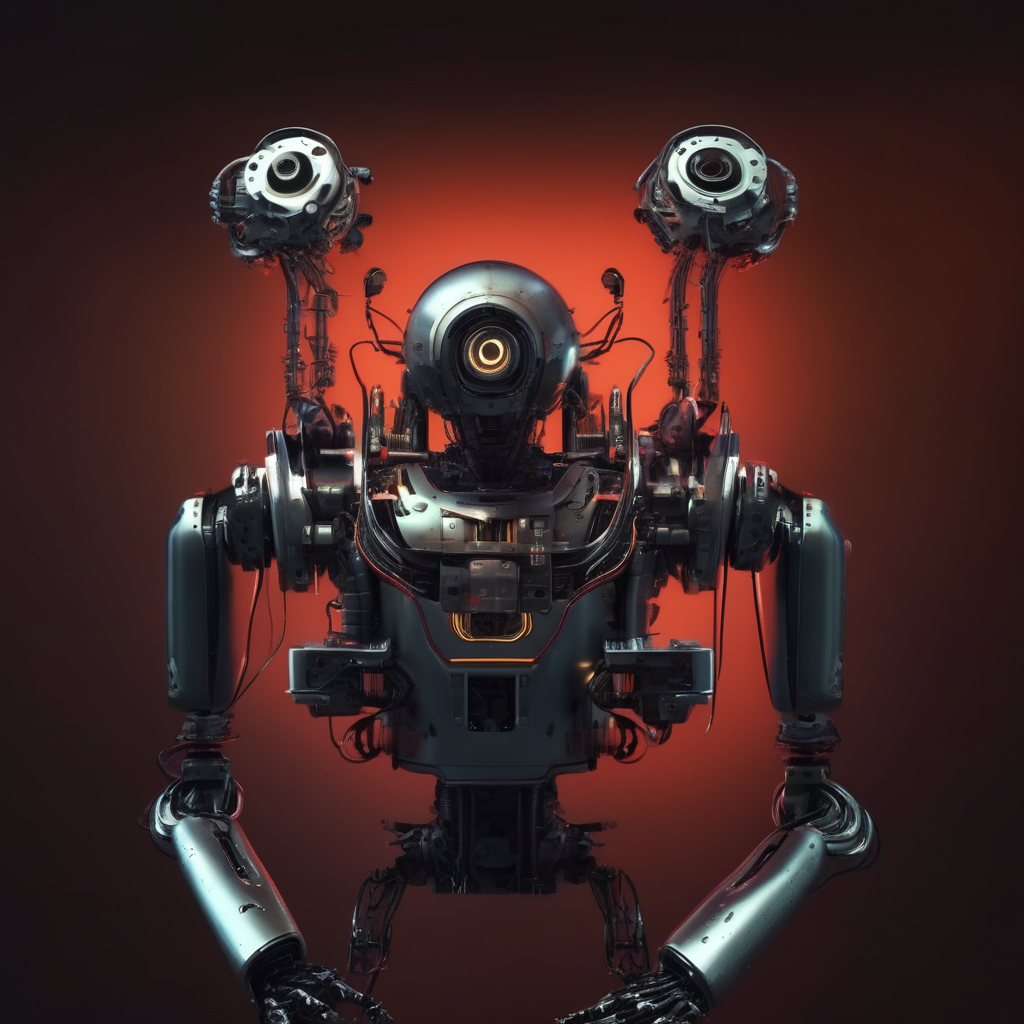

In [30]:
images = pipe(
    prompt,
    image=image,
    control_image=depth_image,
    strength=0.99,
    num_inference_steps=50,
    controlnet_conditioning_scale=controlnet_conditioning_scale
).images
images[0]